# MNIST Code Along with ANN

Before we start working with Convolutional Neural Networks (CNN), let's model the MNIST dataset using only
linear layers.
In this exercise we'll use the same logic laid out in the ANN notebook. We'll reshape the MNIST data from a
28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.


### Perform standard imports

Torchvision should have been installed by the environment file during setup. If not, you can install it now. At the
terminal with your virtual environment activated, run

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Load the MNIST dataset

PyTorch makes the MNIST dataset available through torchvision. The first time it's called, the dataset will be
downloaded onto your computer to the path specified. From that point, torchvision will always look for a local
copy before attempting another download.

### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize,
etc.) to the incoming data.
For this exercise we only need to convert images to tensors.

In [4]:
# Transforming the MNIST images to Tensors
transform = transforms.ToTensor()

In [5]:
# Downloading our MNIST image dataset for the train set
train_data = datasets.MNIST(root='data_cnn',
                            train =True,
                            transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data_cnn
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set

There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before,
torchvision will only download this once, and in the future will look for the local copy.

In [6]:
# Downloading our MNIST image dataset for the test set
test_data = datasets.MNIST(root='data_cnn', 
                           train =False,
                           transform=transform)

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data_cnn
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [9]:
type(test_data)

torchvision.datasets.mnist.MNIST

### Let's Examine the train dataset

In [10]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Calling the first record from train_data returns a two-item tuple. The first item is our 28x28 tensor representing
the image. The second is a label, in this case the number "5".

In [37]:
image, label = train_data[10]

In [38]:
image.shape

torch.Size([1, 28, 28])

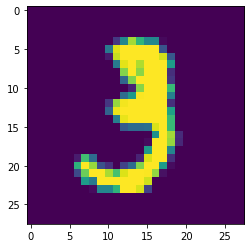

In [39]:
# Let's visualize the image using matplotlib
plt.imshow((image.reshape(28,28)))

### Batch loading with DataLoader

Our training set contains 60,000 records. If we look ahead to our model we have 784 incoming features, hidden
layers of 120 and 84 neurons, and 10 output features. Including the bias terms for each layer, the total number of
parameters being trained is:

For this reason it makes sense to load training data in batches using DataLoader.

In [40]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size = 100,
                          shuffle= True )
test_loader = DataLoader(test_data, batch_size = 500,
                        shuffle=False)

In the cell above, train_data is a PyTorch Dataset object (an object that supports data loading and sampling).
The batch_size is the number of records to be processed at a time. If it's not evenly divisible into the dataset,
then the final batch contains the remainder.
Setting shuffle to True means that the dataset will be shuffled after each epoch.

*NOTE:* DataLoader takes an optional num_workers parameter that sets up how many subprocesses to use
for data loading. This behaves differently with different operating systems so we've omitted it here. See the
docs for more information.

#### View a batch of images
Once we've defined a DataLoader, we can create a grid of images using torchvision.utils.make_grid

Labels: [(x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4) (x:4)]


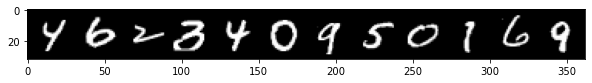

In [41]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'(x:4)'))

# Grab the first batch of images
for images, labels in train_loader:
    break

# print the first 12 labels
print('Labels:', labels[:12].numpy())

# Print the first 12 images
im =make_grid(images[:12], nrow=12) # the default nrows is 8
plt.figure(figsize=(10,4))

# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

### Define the model

For this exercise we'll use fully connected layers to develop a multilayer perceptron.
Our input size is 784 once we flatten the incoming 28x28 tensors.
Our output size represents the 10 possible digits.
We'll set our hidden layers to [120, 84] for now. Once you've completed the exercise feel free to come back and
try different values.
Labels: [ 0 5 7 8 6 7 9 7 1 3 8 4]
try different values.

In [91]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [92]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Count the model parameters

This optional step shows that the number of trainable parameters in our model matches the equation above.

In [93]:
for param in model.parameters():
    print(param.numel())


94080
120
10080
84
840
10


In [94]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [95]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


### Define loss function & optimizer

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Flatten the training data

The batch tensors fed in by DataLoader have a shape of [100, 1, 28, 28]:

In [97]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [98]:
images.shape

torch.Size([100, 1, 28, 28])

In [99]:
images.view(100,-1).shape
# Note that the -1 will multply 1 by 28 by 28 which is =784

torch.Size([100, 784])

### Train the model

This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy
on the same plot.

In [102]:
# Setting up time to train the model
import time
start_time = time.time()

# TRAIN
epochs = 10
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    
    # Run the training batches
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred= model(x_train.view(100, -1))# Here we flatten x_train
        loss =criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        
        predicted =torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr +=batch_corr
        
        # Updata parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print interim results
        if b%200 ==0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epochs: {i} batch: {b} losses: {loss.item()} accuracy: {acc}')
        
    # Updating the training losses and accuracy for each epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            
            # Apply the model
            y_val =model(x_test.view(500,-1))# Here we flatten x_test
            
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data,1)[1]
            tst_corr +=(predicted==y_test).sum()
        
    # Update test loss and accuracy for each epoch
    loss= criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')



Epochs: 0 batch: 200 losses: 0.06815929710865021 accuracy: 97.52
Epochs: 0 batch: 400 losses: 0.08500464260578156 accuracy: 97.545
Epochs: 0 batch: 600 losses: 0.10887953639030457 accuracy: 97.56
Epochs: 1 batch: 200 losses: 0.13451822102069855 accuracy: 98.085
Epochs: 1 batch: 400 losses: 0.1158832386136055 accuracy: 98.1725
Epochs: 1 batch: 600 losses: 0.06157029792666435 accuracy: 98.07166666666667
Epochs: 2 batch: 200 losses: 0.03422800078988075 accuracy: 98.52
Epochs: 2 batch: 400 losses: 0.009336505085229874 accuracy: 98.4525
Epochs: 2 batch: 600 losses: 0.04636434093117714 accuracy: 98.48333333333333
Epochs: 3 batch: 200 losses: 0.04444841295480728 accuracy: 98.815
Epochs: 3 batch: 400 losses: 0.09162892401218414 accuracy: 98.7475
Epochs: 3 batch: 600 losses: 0.05418621003627777 accuracy: 98.69666666666667
Epochs: 4 batch: 200 losses: 0.03512982651591301 accuracy: 98.93
Epochs: 4 batch: 400 losses: 0.038683030754327774 accuracy: 98.9375
Epochs: 4 batch: 600 losses: 0.02202948182

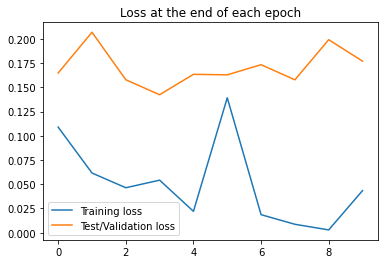

In [105]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test/Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

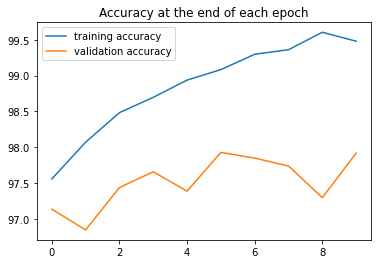

In [106]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Evaluate Test Data

In [107]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9714), tensor(9685), tensor(9744), tensor(9766), tensor(9739), tensor(9793), tensor(9785), tensor(9774), tensor(9730), tensor(9792)]

Test accuracy: 97.920%


However, we'd like to compare the predicted values to the ground truth (the y_test labels), so we'll run the test
set through the trained model all at once.

In [108]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [109]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1)) # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9792/10000 =  97.920%
